PREDICTING PRICE WITH CITY

Goal

Build a model to predict house price based on city

In [1]:
#Import Libraries
import pandas as pd
import warnings
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=UserWarning)

For this project i would be using a wrangle function to clean my data

In [2]:
def wrangle(filepath):
    #Read csv file
    df = pd.read_csv(filepath)
    df.drop(columns="prev_sold_date", inplace=True)
    #drop NAN values
    df.dropna(how="any", inplace=True)
    #Create a new column called "price_in_USD" using "price"
    df["price_in_USD"] = df["price"].astype(int)
    #Convert "acre_lot" to m2
    df["area_in_m2"] = (df["acre_lot"] * 4_046.86).astype(int)
    #Calculate price per m2
    df["price_per_m2"] = (df["price_in_USD"] / df["area_in_m2"]).round(0)
    #Subset Data: i would be focusing on the houses in the state "Puerto Rico" < 400,000 and that are for_sale
    mask_sale=df["status"]=="for_sale"
    mask_state=df["state"]=="Puerto Rico"
    mask_price = df["price_in_USD"]< 400_000
    df=df[mask_sale & mask_state & mask_price]
    #Subset Data: Remove outliers in "area_in_m2"
    low,high=df["area_in_m2"].quantile([0.1,0.9])
    mask_area = df["area_in_m2"].between(low,high)
    df = df[mask_area]
    df.drop(columns=["street","state","zip_code","house_size","brokered_by","status","price","bed","bath","acre_lot"], inplace=True)
    df = df.reset_index(drop=True)
    return df
    

In [3]:
df = wrangle("realtor-data.csv")

In [4]:
df.tail()

,city,price_in_USD,area_in_m2,price_per_m2
924,Carolina,145000,364,398.0
925,Carolina,72500,242,300.0
926,Carolina,100000,323,310.0
927,Carolina,130000,323,402.0
928,Carolina,147000,364,404.0


Spliting my data to creating my test dataset

In [5]:
cutoff = int(len(df) * 0.8)

In [6]:
dt = df.iloc[:cutoff]
dt.tail()

,city,price_in_USD,area_in_m2,price_per_m2
738,Carolina,99900,323,309.0
739,Carolina,136000,242,562.0
740,Carolina,140000,1052,133.0
741,Canovanas,29900,364,82.0
742,Canovanas,115000,526,219.0


In [7]:
Test_data = df.iloc[cutoff:]
Test_data.head()

,city,price_in_USD,area_in_m2,price_per_m2
743,Loiza,103000,242,426.0
744,Carolina,165000,364,453.0
745,Canovanas,49900,323,154.0
746,Canovanas,72000,404,178.0
747,Canovanas,65000,242,269.0


Saving my test_data DataFrame in a CSV format

Test_data.to_csv("realtor-data_test.csv", index=False)

Creating my feature matrix X_train and target vector y_train

In [8]:
target = "price_per_m2"
features = ["city"]
y_train = dt[target]
X_train = dt[features]

calculating the baseline mean absolute error for my model

In [9]:
 y_mean = y_train.mean()
 y_pred_baseline = [y_mean] * len(y_train)
 Baseline_MAE = mean_absolute_error(y_train, y_pred_baseline)
 rounded_y_mean = round(y_mean, 2)
 rounded_Baseline_MAE = round(Baseline_MAE, 2)
 print("Mean_House_Price:", rounded_y_mean)
 print("Baseline_MAE:", rounded_Baseline_MAE)

Mean_House_Price: 301.18
Baseline_MAE: 155.26


Now i build my model by creating a pipeline that contain all the transformers neccesary
and a predictor

In [10]:
 model = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     SimpleImputer(),
     Ridge()
 )

In [11]:
  model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Calculating the training mean absolute error

In [12]:
 y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 133.79


With a Training MAE less than my Baseline MAE This suggests that my model is effective at reducing error 
compared to a naive model.

Importing my test Data

In [13]:
X_test = pd.read_csv("realtor-data_test.csv")

In [14]:
X_test.drop(columns= ["price_in_USD","area_in_m2","price_per_m2"],inplace=True)

Using my model to generate a series of prediction for X_test

In [15]:
y_test_pred = pd.Series(model.predict(X_test))

In [16]:
y_test_pred.astype(int)

0      200
1      356
2      150
3      150
4      150
      ... 
181    356
182    356
183    356
184    356
185    356
Length: 186, dtype: int32

In [17]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs).round(2)
feat_imp

city_Humacao           -5.72
city_Fajardo           -7.02
city_Vega Baja         -7.29
city_Sabana Grande      7.35
city_Penuelas         -12.26
                       ...  
city_Utuado          -122.96
city_Naranjito       -128.27
city_Trujillo Alto    177.70
city_San Juan         216.68
city_Guaynabo         274.28
Length: 74, dtype: float64

Interpretation by visible output above: From the result above, the feature "city_Guaynabo" has the highest
positive coefficient ("274.28"), meaning it has more significant positive impact on the target variable 
("house price") when compaired to "city_San Juan" ("216.68"). The closer the coefficient is to zero, 
the less influence that feature ("city") has on the target variable ("house price")

creating a horizontal bar chart that shows the 10 most influential coefficients for my model

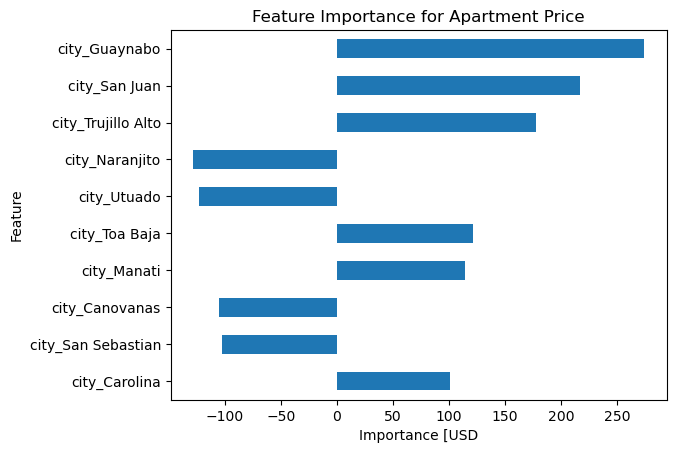

In [18]:
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Importance [USD")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");

Printing the equation that my model has determined for predicting house price based on city

y = B0 + (B1*X1) + (B2*X2) + ... + (Bn*Xn)

In [19]:
intercept = model.named_steps["ridge"].intercept_
intercept

255.5297162527304

In [20]:
coefficients = model.named_steps["ridge"].coef_
print(coefficients[:5])

[ -15.6864775   -23.47085889   92.41777361 -102.69308111  -93.823773  ]


In [21]:
equation_parts = []
feat_items = list(feat_imp.items())

# Get the first two items
for i, (f, c) in enumerate(feat_items[:2]):
    equation_parts.append(f"({round(c, 2)} * {f})")

# Add the last item
f_last, c_last = feat_items[-1]
equation_parts.append(f"... + ({round(c_last, 2)} * {f_last})")

# Combine and print the equation
equation = f"price = {intercept.round(2)} + " + " + ".join(equation_parts)
print(equation)

price = 255.53 + (-5.72 * city_Humacao) + (-7.02 * city_Fajardo) + ... + (274.28 * city_Guaynabo)
